# Match to reference catalog

Following the Detect and Measure Sources notebook we will perform matching to reference catalogs in this notebook. Matching between catalogs is performed as follows:

1. Configure the reference object loader and reference catalog,
2. produce a science catalog of sources to match, 
3. produce a reference catalog of sources that overlap the area of interest,
4. bundle the two created catalogs and pointing metadata and finally
5. preform catalog matching.

Like last time, first step is to setup the Spark paths. This only needs to be run once per lifetime of a notebook.

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

conf = SparkConf()
conf.setAppName("Something's happening.")
conf.setMaster("spark://ip-172-31-37-93.us-west-2.compute.internal:7077")
conf.set("spark.executor.memory", '12g')
conf.set('spark.executor.cores', '4')
sc = SparkContext(conf=conf)
sc.addPyFile("/home/ec2-user/lsstspark.zip")

### How LSST Stack handles matching

In the LSST Stack there are two different object matching Tasks `RefMatchTask` and `DirectMatchTask`. They differ from each other mainly by the choice of the matcher that is used. Dependant on the intended purpose either one is appropriate. For example, solving for astrometry or fitting WCS requires a better (and slower) matcher than a matcher that might be used to match objects so photometric calibration can be performed (especially once WCS is known).

**Matchers** are Tasks that are used to do the actual matching of objects. There are several different matchers: `MatchOptimisticB`, `MatchPessimisticB` and then the matching in `DirectMatchTask` is performed by a `matchRaDec` function from `afw.table` which is a `C++` implementation between `Simple*` objects (i.e. `SimpleRecord`, `SimpleTable` etc..). Not sure why that one is special and not a registered matcher.                           

Apart from that, matching to reference catalogs is a very similar process in both cases. `RefMatchTask` seems to be a more general implementation of matching than `DirectMatchTask`. To match a science catalog to reference catalog (both are `SourceCatalog` objects) we need a :

1. Matcher, 
2. Science Source Selector, 
3. Reference Source Selector 
4. and a Reference Object Loader.                    

**Source selectors** are Tasks that take in a `SourceCatalog` and from it select sources as instructed by their configurations. This enables various color cuts, magnitude cuts, SN cuts etc. Strictly speaking, Matchers preform matches between two `SourceCatalog`s but it is not advisable to use source catalogs not produced by a Source Selector.     

A **Reference Object Loader** is a Task that essentially preforms the "translations" between the data and the reference catalog. For example, it maps filter name(s) in the header(s) to filter names in the reference catalog, it can interpret the pointing information and find out which reference catalog objects cover that general area, additionally - it can read in those objects, trim them to the exposure bounding box + padding and return a catalog of reference objects within that area. To perform the science to reference catalog data translations **Indexers** are used. I think only one Indexer exists right now - the `HtmIndexer`. To read the actual data in and out the `Butler` is applied generously. 

### Configuring Reference Object Loader and Reference Catalog

To setup the matching process we need to declare two configurations: 

1. reference catalog configuration - instructing the indexer where it can find the reference catalogs, what's the name of the specific reference catalog we want to use and what type of indexer is appropriate to read that catalog. In this case it's PanStarrs catalog and a HTM (Hierarchical Triangular Mesh) indexer. 

2. reference object loader configuration - translates incoming science data into something the matcher can understand. In this case it maps the filter names found in the exposure headers and metadata into corresponding filter names that exist in the reference catalog. 

We set up our reference catalog configuration (`refCatConf`) and its location on disk, as well as the reference object loader config. Since our data was taken in the `VR` filter (450-750nm or so) and there is no exactly corresponding filter in the reference catalog. Filter `r` was selected as closest matching filter to `VR`.

In [2]:
import lsstspark.utils as utils

# reference catalog setup
refCatConf = utils.DatasetConfig()
refCatConf.ref_dataset_name  = "ps1_pv3_3pi_20170110"
refCatConf.indexer = "HTM"
refCatLoc = "s3://dinolsstspark/small_ref_cats/"

# reference object setup 
refObjConf = utils.LoadIndexedReferenceObjectsConfig()
refObjConf.filterMap = {'u': 'g', 'Y': 'y', "VR": "r"}
refObjConf.ref_dataset_name = refCatConf.ref_dataset_name

### Creating the science catalog

Matching is performed between two `SourceCatalog`s - so we need to create those. We can create the science source catalog by detecting all objects on an exposure. We don't need everything returned by source detection - only the science source catalog so we select only those from the full output (see the DetectMeasureEstimate notebook).                

In [3]:
import lsstspark.detectSources as detectSources

# register exposures we want to process
calexppath = "s3://dinolsstspark/sci_exposures/calexp-0308355_01.fits"
expPathsRDD = sc.parallelize([calexppath])

#ingest them as ExposureF objects
expRDD = expPathsRDD.map(utils.toExposureF)

#setup detection parameters and ten estimate PSF, detect and measure sources
sourceDetector = detectSources.detect_and_measure(psfIterations=2, doMeasurePsf=True)
estDetMeasRDD = expRDD.map(sourceDetector)

# we only need the source catalogs - or in this case a source catalog
scienceCatsRDD = estDetMeasRDD.map(lambda x: x[2])

### Creating the reference catalog

The reference catalog can be created by mapping `create_reference_catalogs` function to exposures. This function essentially performs the function of a Reference Object Loader - it:

1. translates the pointing information into IDs of shards overlapping that area,
2. loads them from disk, 
3. then trims them to bounding box of the exposure 
4. and merges them into a single contiguous `SourceCatalog`.           

In [4]:
import lsstspark.refMatchTask as refMatch

refCatCreator = refMatch.create_reference_catalogs(refCatConf, refCatLoc, refObjConf)
referenceCatsRDD = expRDD.map(refCatCreator)

### Bundling all required data

Since object matching performs on pairs of catalogs we zip them together to create a catalog pair.

In [5]:
catPairsRDD = scienceCatsRDD.zip(referenceCatsRDD)

Unfortunately, this is not sufficient information to succesfully match the two catalogs just yet. We need a WCS of the exposures in question and the filter on which the match will be preformed. This data is stored in the exposure's header and we can retrieve it by using `getExpMetadata`.                           
We zip the metadata with the catalog pairs to get the triplets `([(scienceCat, referenceCat), metadata], [(), ], ....)`.

In [6]:
metadataRDD = expRDD.map(utils.get_exp_metadata)
catPairsWithMetadataRDD = catPairsRDD.zip(metadataRDD)

### Matching 

Finally we perform the matching by mapping `match_sources_with_metadata` function onto catalog pairs with metadata RDD. This function essentially performs the function of `RefMatchTask` - it instantiates a `ScienceSourceSelectorTask`, `ReferenceSourceSelectorTask` and a `MatchPesimisticBTask` and performs the matching. 

The `match_sources_with_metadata` function returns a catalog (`BaseCatalog` object) that lists ID's of objects as indexed in the reference and science catalogs. The third returned value are the distances between the matched objects.

In [7]:
matchesRDD = catPairsWithMetadataRDD.map(refMatch.match_sources_with_metadata)
matches = matchesRDD.first()
matches

<class 'lsst.afw.table.base.base.BaseCatalog'>
      first       second     distance    
----------------- ------ ----------------
78081959041307962     13  0.0103651790029
78091959050415871     14  0.0256262063418
78011959047454146     16  0.0102353520044
78031959069311184     29   0.043904379098
77991959069990104     31    0.04082956159
78001959073892277     32  0.0847791818993
78061959098451155     42  0.0109264255956
78001959128208885     57  0.0326495089253
78081959176091552     72  0.0119866349674
78031959178595907     75  0.0309970651455
              ...    ...              ...
78011962081713412   1086  0.0123027512278
78071962107933266   1092  0.0548801740331
78111962106554400   1093  0.0151282015728
78051962150097837   1109  0.0154618817366
78031962154116405   1110   0.027840562243
78061962162542801   1118  0.0775039118552
78011962169844067   1119   0.014658229295
78021962175529230   1123  0.0157502701142
78021962181842076   1124 0.00934049938472
77991962192972597   1132  0.0

### Inspecting the data.

We can, for example, overplot the positions of detected objects (circles) and reference objects (crosses) on the used image. First, let's grab all the data we would need. This includes unpacking the `BaseCatalog` of matches and resolving the index-to-index matchings into a list of `ReferenceMatch` object.

`ReferenceMatch` objects contain a `first`, a `second` and a `distance` fields. The `first` and `second` fields depend on the order of objects when calling `match_soruces` function. In our case `first` stores IDs belonging to the reference catalog and `second` IDs belonging to ingoing science catalog. 

In [8]:
exposure = expRDD.first()
scicat   = scienceCatsRDD.first()
refcat   = referenceCatsRDD.first()

unpacked_matches = utils.unpackMatches(matches, refcat, scicat)

In the plot reference sources are marked with a white diamond while the science sources are marked with an orange circle. Notice how access to pixel coordinates for reference catalog does not correspond to how access to pixel coordinates of science sources is done.

/home/ubuntu/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/visualization/stretch.py:368: RuntimeWarning: overflow encountered in sinh
  np.sinh(values, out=values)


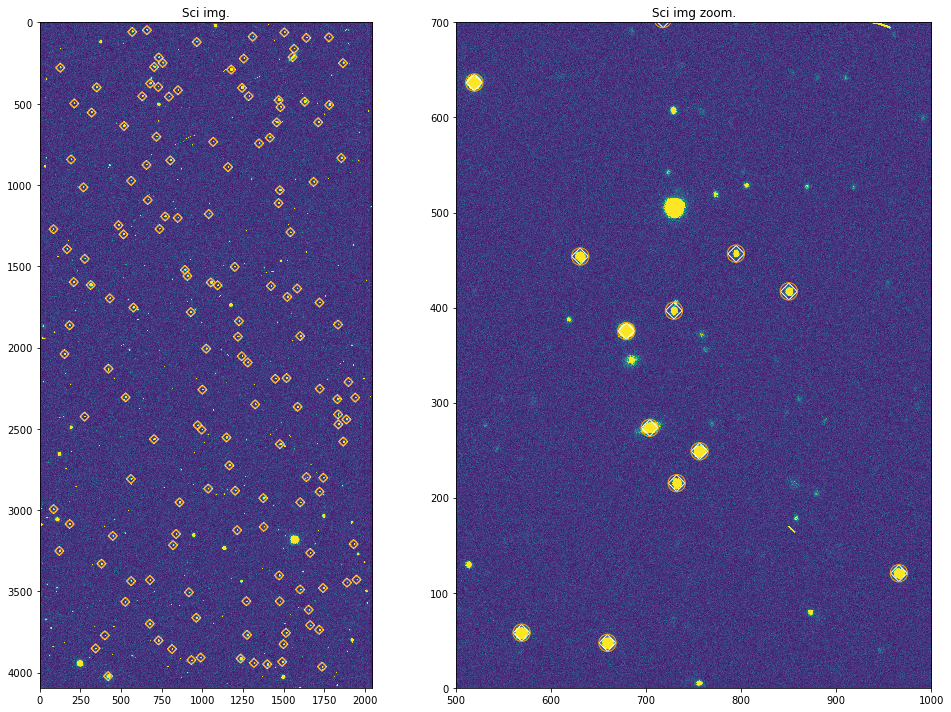

In [11]:
%matplotlib inline
import astropy.visualization as visz
import matplotlib.pyplot as plt

def imgnorm(img):
    minv, maxv = visz.ZScaleInterval().get_limits(img)
    norm = visz.ImageNormalize(vmin=minv, vmax=maxv, stretch=visz.SinhStretch())
    return norm

img  = exposure.getImage()
norm = imgnorm(img.array)

fig, axes = plt.subplots(1, 2, figsize=(14, 10))
[ax.imshow(img.array, norm=norm) for ax in axes]

for match in unpacked_matches:
    refsrc = match.first
    scisrc = match.second 
    i=0
    for ax in axes:
        ax.scatter(refsrc.get("centroid_x"), refsrc.get("centroid_y"), marker="D",  s=40+i*100, edgecolor="white", 
                   facecolor="None")
        ax.scatter(scisrc.getX(), scisrc.getY(), marker="o",  s=50+i*250, edgecolor="orange", facecolor="None")
        i+=1
 
axes[0].set_title("Sci img.")
axes[1].set_title("Sci img zoom.")                       
axes[1].set_xlim(500, 1000)
axes[1].set_ylim(0, 700)

plt.tight_layout()
plt.show()

There is only 150 objects or so in our matching but we can look at some more significant matching statistics such as distances between matched objects and their dependance on measured flux. In this case the smaller the flux the larger the expected dispersion is.

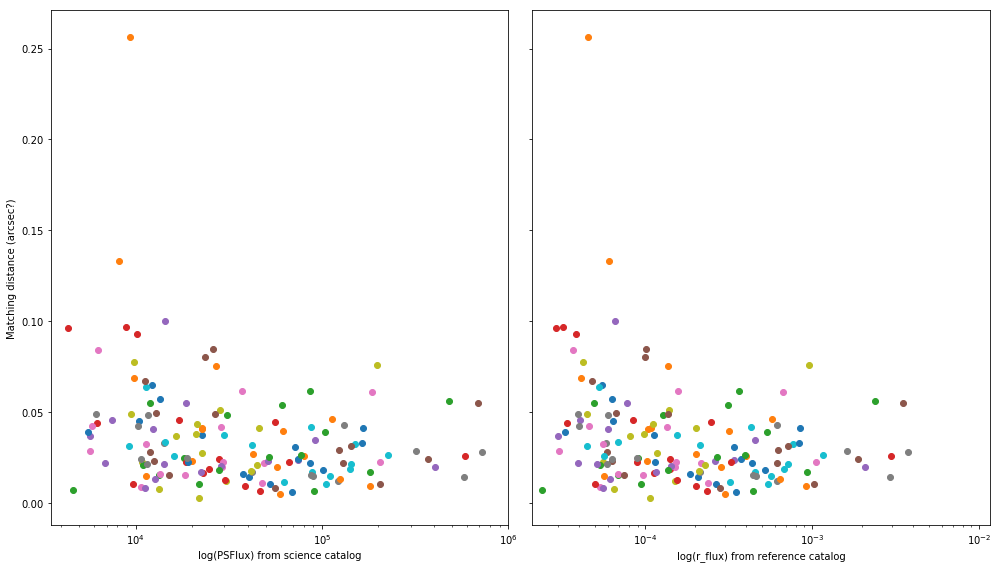

In [12]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

for match in unpacked_matches:
    axes[0].scatter(match.second.getPsfFlux(), match.distance,)
    axes[1].scatter(match.first.get("r_flux"), match.distance,)

[ax.set_xscale("log") for ax in axes]

axes[0].set_ylabel("Matching distance (arcsec?)")

axes[0].set_xlabel("log(PSFlux) from science catalog")
axes[1].set_xlabel("log(r_flux) from reference catalog")

axes[0].set_xlim(3500, 1000000)

plt.tight_layout()
plt.show()